In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install flask-ngrok

In [ ]:
!pip install pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.9/181.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 19.1 MB/s eta 0:00:00


In [ ]:
%load_ext tensorboard

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE
from pytorch_lightning import Trainer
import pytorch_lightning as pl
from torch.optim import Adam
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint  # ModelCheckpoint 임포트
from pytorch_lightning.callbacks.early_stopping import EarlyStopping  # EarlyStopping 콜백도 임포트

In [47]:
# Google Drive에서 데이터 로드
train_data_path = "/content/drive/MyDrive/종설프1_5팀/전처리.ipynb/train_data.csv"
test_data_path = "/content/drive/MyDrive/종설프1_5팀/전처리.ipynb/test_data.csv"

# 데이터 로드
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

# 스케일링
scaler = MinMaxScaler()
df_train['feed_pressure'] = scaler.fit_transform(df_train[['feed_pressure']])
df_test['feed_pressure'] = scaler.transform(df_test[['feed_pressure']])

# 시간 인덱스 추가
df_train['time_idx'] = range(len(df_train))
df_test['time_idx'] = range(len(df_train), len(df_train) + len(df_test))

# 학습 및 테스트 데이터 병합
df_total = pd.concat([df_train, df_test], ignore_index=True)

### 데이터 준비 및 설정
우선 max_encoder_length와 max_prediction_length를 설정하여 데이터의 인코더 및 예측 길이를 정의합니다.

In [49]:
# max_encoder_length와 max_prediction_length 설정
total_data_length = len(df_train)
max_encoder_length = max(10, total_data_length // 10)  #12시간
max_prediction_length = 1  #2시간

print(f"Max encoder length: {max_encoder_length} entries")
print(f"Max prediction length: {max_prediction_length} entries")

# 그룹 ID 설정
df_total["group"] = "series"  # 단일 시계열일 경우 고유 그룹 지정

Max encoder length: 892 entries
Max prediction length: 1 entries


### TimeSeriesDataSet 생성
TimeSeriesDataSet을 사용해 데이터를 생성합니다. 여기에는 타겟, 그룹화 방식, 그리고 변동하는 시계열 컬럼을 정의합니다.


In [50]:
training = TimeSeriesDataSet(
    df_total[lambda x: x.time_idx < len(df_train)],  # 학습 데이터만 사용
    time_idx="time_idx",
    target="feed_pressure",  # 타겟 변수
    group_ids=["group"],  # 그룹화
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    time_varying_known_reals=["time_idx"],  # 시간 관련 변수
    time_varying_unknown_reals=["feed_pressure"],  # 예측 대상 변수
    target_normalizer=GroupNormalizer(transformation="relu")  # 정규화
)

### DataLoader 생성
DataLoader를 생성하여 모델이 데이터를 학습할 수 있도록 준비합니다.

In [51]:
# 데이터 로더 재생성
train_dataloader = training.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dataloader = training.to_dataloader(train=False, batch_size=32, num_workers=0)

### Temporal Fusion Transformer 모델 생성
Temporal Fusion Transformer 모델을 생성하여 데이터셋을 학습할 준비를 합니다.

In [52]:
from torchmetrics import MeanAbsoluteError

# Define the loss function
loss = MeanAbsoluteError()

# Temporal Fusion Transformer 모델 생성
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,  # 학습률
    hidden_size=16,  # 모델의 잠재 표현 크기
    attention_head_size=1,  # 어텐션 헤드 개수 (패턴 포착)
    dropout=0.1,  # 과적합 방지
    hidden_continuous_size=16,  # 연속형 변수의 임베딩 크기
    loss=loss,  # 손실 함수 (loss 변수 사용)
    log_interval=10,  # 학습 로그 출력 빈도
    reduce_on_plateau_patience=3,  # 손실이 개선되지 않을 시 학습률 줄이는 시점
    optimizer="adam"
)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


### LightningModule 정의 및 Trainer 설정
PyTorch Lightning을 이용하여 모델 학습을 보다 쉽게 관리할 수 있도록 합니다.


In [53]:
class TFTWrapper(pl.LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model
        self.train()  # 명시적으로 학습 모드로 설정

    def forward(self, x):
        # 모든 입력 데이터를 모델의 디바이스로 이동
        x = {key: value.to(self.device) if isinstance(value, torch.Tensor) else value for key, value in x.items()}
        return self.tft_model(x)

    def training_step(self, batch, batch_idx):
        # 모든 데이터를 모델의 디바이스로 이동
        self.train()  # 학습 스텝에서 다시 학습 모드로 전환
        x, y = batch
        x = {key: value.to(self.device) if isinstance(value, torch.Tensor) else value for key, value in x.items()}

        # y가 튜플인 경우, 첫 번째 요소만 가져오기
        if isinstance(y, tuple):
            y = y[0]
        y = y.to(self.device)

        y_hat = self(x)["prediction"]
        loss = self.tft_model.loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # 모든 데이터를 모델의 디바이스로 이동
        x, y = batch
        x = {key: value.to(self.device) if isinstance(value, torch.Tensor) else value for key, value in x.items()}

        # y가 튜플인 경우, 첫 번째 요소만 가져오기
        if isinstance(y, tuple):
            y = y[0]
        y = y.to(self.device)

        y_hat = self(x)["prediction"]
        loss = self.tft_model.loss(y_hat, y)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.03)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5),
            'monitor': 'val_loss'
        }
        return [optimizer], [lr_scheduler]


## 모델 학습

In [54]:
# Google Drive가 체크폰트 저장 경로 설정
local_checkpoint_dir = "/content/checkpoints/"
drive_checkpoint_dir = "/content/drive/MyDrive/종설프1_5팀/checkpoints/"
os.makedirs(local_checkpoint_dir, exist_ok=True)
os.makedirs(drive_checkpoint_dir, exist_ok=True)

# 모델 저장
model_save_path = "/content/drive/MyDrive/종설프1_5팀/model.pth"

# 기존 체크폰트 파일 삭제 함수
def delete_existing_checkpoints(checkpoint_dir):
    if os.path.exists(checkpoint_dir):
        for filename in os.listdir(checkpoint_dir):
            file_path = os.path.join(checkpoint_dir, filename)
            try:
                if os.path.isfile(file_path):
                    os.remove(file_path)
                    print(f"Deleted checkpoint file: {file_path}")
            except Exception as e:
                print(f"Failed to delete {file_path}: {e}")


# 가장 최근 체크포인트 찾기
def get_latest_checkpoint(checkpoint_dir):
    if os.path.exists(checkpoint_dir):
        checkpoints = [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.endswith(".ckpt")]
        if checkpoints:
            return max(checkpoints, key=os.path.getctime)  # 가장 최근 파일 반환
    return None

In [55]:
# TFT 모델을 TFTWrapper로 감싸기
tft.to('cuda')
wrapped_tft = TFTWrapper(tft).to('cuda')

# Early Stopping Callback 추가
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=10,
    verbose=True,
    mode="min"
)

# 모델 저장 경로
checkpoint_callback = ModelCheckpoint(
    dirpath=local_checkpoint_dir,
    filename="tft-{epoch:02d}-{val_loss:.2f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    save_last=True
)

# 학습 실행 시 체크포인트 콜백 포함
trainer = Trainer(
    max_epochs=30,
    accelerator="gpu",
    devices=1,
    gradient_clip_val=0.3,
    precision=32,
    callbacks=[early_stop_callback, checkpoint_callback],  # 콜백 추가
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


<span style="color:red;">주의: 체크포인트 삭제!</span>

In [57]:
# 기존 체크포인트에서 로드 여부 확인 및 학습 실행
delete_checkpoints = input("기존 체크포인트 파일을 삭제하시겠습니까? (y/n): ").lower()

if delete_checkpoints == 'y':
    print("기존 체크포인트 파일을 삭제합니다.")
    delete_existing_checkpoints(local_checkpoint_dir)
    delete_existing_checkpoints(drive_checkpoint_dir)

    # 새 학습 시작
    trainer.fit(
        model=wrapped_tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader
    )

else:
    print("기존 체크포인트를 유지합니다.")
    latest_checkpoint = get_latest_checkpoint(local_checkpoint_dir)

    if latest_checkpoint:
        print(f"기존 체크포인트에서 로드합니다: {latest_checkpoint}")

        # 체크포인트에서 모델 로드
        loaded_tft = TemporalFusionTransformer.load_from_checkpoint(latest_checkpoint)

        # TFTWrapper로 래핑
        wrapped_tft = TFTWrapper(tft_model=loaded_tft).to(device)

        # 기존 체크포인트에서 로드한 모델로 학습 재개
        trainer.fit(
            model=wrapped_tft,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader
        )

    else:
        print("체크포인트가 없습니다. 새로 학습을 시작합니다.")

        # 새 학습 시작
        trainer.fit(
            model=wrapped_tft,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader
        )


기존 체크포인트 파일을 삭제하시겠습니까? (y/n): y
기존 체크포인트 파일을 삭제합니다.
Deleted checkpoint file: /content/checkpoints/tft-epoch=11-val_loss=0.02.ckpt
Deleted checkpoint file: /content/checkpoints/last.ckpt


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | tft_model | TemporalFusionTransformer | 17.7 K | train
----------------------------------------------------------------
17.7 K    Trainable params
0         Non-trainable params
17.7 K    Total params
0.071     Total estimated model params size (MB)
160       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.036


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 0.026


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.024


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.019


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.017


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.017


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.017


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 0.017. Signaling Trainer to stop.


In [58]:
# 학습 종료 후 가장 좋은 체크포인트 경로 출력
print(f"Best checkpoint saved at: {checkpoint_callback.best_model_path}")

Best checkpoint saved at: /content/checkpoints/tft-epoch=16-val_loss=0.02.ckpt


## 서버구축

In [59]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


--2024-12-01 13:47:51--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 75.2.60.68, 13.248.244.96, 99.83.220.108, ...
Connecting to bin.equinox.io (bin.equinox.io)|75.2.60.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.28M  8.08MB/s    in 1.6s    

2024-12-01 13:47:53 (8.08 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [60]:
!./ngrok authtoken cr_2pQNo2X1zqJCJbgu2vzvGoq8ubY

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


## 모델 다시 로드

In [63]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## ROLLING 방식

In [70]:
# 'group' 컬럼 확인 및 추가
if "group" not in df_test.columns or df_test["group"].isnull().any():
    df_test["group"] = "series"  # 기본 그룹 값 설정

In [71]:
# Rolling Prediction 실행 전에 데이터 유효성 확인
if len(df_test) < max_encoder_length:
    raise ValueError(
        f"Test dataset length ({len(df_test)}) is shorter than max_encoder_length ({max_encoder_length})."
    )

In [87]:
def rolling_predict_until_condition(
    model, train_dataset, max_encoder_length, scaler, condition_value=17, tolerance=0.1, device="cuda"
):
    """
    Rolling 방식으로 train의 첫 max_encoder_length 데이터를 바탕으로 조건 만족 시까지 예측합니다.

    Args:
        model: PyTorch 모델.
        train_dataset: 학습에 사용된 데이터셋 (DataFrame 형태).
        max_encoder_length: 롤링 윈도우의 길이.
        scaler: MinMaxScaler (스케일링 복원을 위해 필요).
        condition_value: 예측이 중단되는 조건 값 (예: 17).
        tolerance: 조건 값에 대한 허용 오차.
        device: 사용할 디바이스 (default: "cuda").

    Returns:
        predictions (list): 예측된 값의 리스트.
    """
    model = model.to(device)
    model.eval()

    # Initialize with the first encoder window from the training data
    input_data = train_dataset.iloc[:max_encoder_length].copy()
    predictions = []

    # Add group column if missing
    if "group" not in input_data.columns:
        input_data["group"] = "series"

    step = 0
    while True:
        try:
            # Create TimeSeriesDataSet for rolling prediction
            rolling_dataset = TimeSeriesDataSet(
                data=input_data,
                time_idx="time_idx",
                target="feed_pressure",
                group_ids=["group"],
                max_encoder_length=max_encoder_length,
                max_prediction_length=1,
                static_categoricals=[],
                time_varying_known_reals=["time_idx"],
                time_varying_unknown_reals=["feed_pressure"],
                target_normalizer=GroupNormalizer(transformation="relu"),
                min_encoder_length=1,
                allow_missing_timesteps=True,
            )

            rolling_dataloader = rolling_dataset.to_dataloader(train=False, batch_size=1)

            # Predict the next value
            with torch.no_grad():
                input_batch = next(iter(rolling_dataloader))
                input_batch = {key: value.to(device) for key, value in input_batch[0].items()}
                prediction = model(input_batch)["prediction"].cpu().numpy().squeeze()

            # Restore the scaled prediction to original scale
            prediction_actual = scaler.inverse_transform([[prediction]]).flatten()[0]
            predictions.append(prediction_actual)

            print(f"Step {step}: Predicted Value = {prediction_actual}")

            # Check if the condition is met
            if abs(prediction_actual - condition_value) <= tolerance:
                print(f"Condition met: Predicted value is within tolerance of {condition_value}. Stopping prediction.")
                break

            # Update rolling input data with new predicted value
            new_time_idx = input_data["time_idx"].iloc[-1] + 1
            new_row = {
                "time_idx": new_time_idx,
                "feed_pressure": float(prediction),
                "group": "series",
            }
            input_data = pd.concat([input_data.iloc[1:], pd.DataFrame([new_row])], ignore_index=True)

            step += 1

        except Exception as e:
            print(f"Error at step {step}: {e}")
            break

    return predictions


In [91]:
rolling_predictions = rolling_predict_until_condition(
    model=wrapped_tft,
    train_dataset=df_train,
    max_encoder_length=max_encoder_length,
    scaler=scaler,
    condition_value=17,
    tolerance=0.1,
    device="cuda",
)

Step 0: Predicted Value = 9.951639924421906
Step 1: Predicted Value = 9.952916045710445
Step 2: Predicted Value = 9.954319488108158
Step 3: Predicted Value = 9.955802669897675
Step 4: Predicted Value = 9.957323029451073
Step 5: Predicted Value = 9.95883545871824
Step 6: Predicted Value = 9.960306344926359
Step 7: Predicted Value = 9.961722082905473
Step 8: Predicted Value = 9.963088056519629
Step 9: Predicted Value = 9.96441466972232
Step 10: Predicted Value = 9.965744629651308
Step 11: Predicted Value = 9.967077936306596
Step 12: Predicted Value = 9.968414589688182
Step 13: Predicted Value = 9.969754735305905
Step 14: Predicted Value = 9.971098082140088
Step 15: Predicted Value = 9.972618514448405
Step 16: Predicted Value = 9.97416688464582
Step 17: Predicted Value = 9.975629476793111
Step 18: Predicted Value = 9.976940374933184
Step 19: Predicted Value = 9.978060436919332
Step 20: Predicted Value = 9.979335976168514
Step 21: Predicted Value = 9.9807530964911
Step 22: Predicted Value 

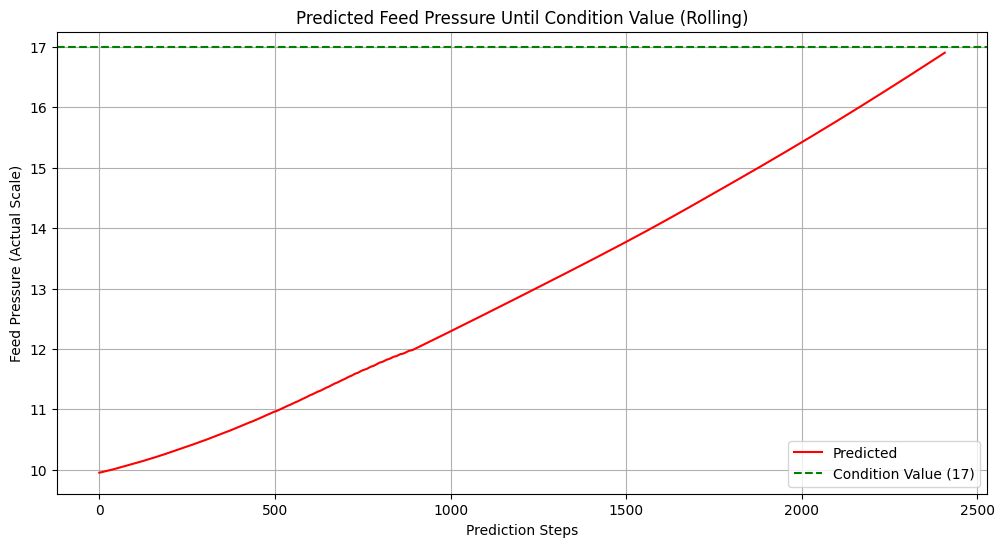

In [92]:
# 결과 시각화 함수
def plot_rolling_predictions(predicted_values, condition_value=17):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(predicted_values)), predicted_values, label="Predicted", linestyle="-", color="red")
    plt.axhline(y=condition_value, color="green", linestyle="--", label=f"Condition Value ({condition_value})")
    plt.xlabel("Prediction Steps")
    plt.ylabel("Feed Pressure (Actual Scale)")
    plt.title("Predicted Feed Pressure Until Condition Value (Rolling)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Rolling Predictions 그래프 호출
plot_rolling_predictions(rolling_predictions, condition_value=17)
